# Example CV2 - Classification with a squeezing feature map

In this example we implement the squeezing feature map together with the implicit linear classifier inspired by [Schuld and Killoran (2018)](https://arxiv.org/abs/1803.07128). 

### Imports

We import PennyLane, the wrapped version of NumPy provided by PennyLane, as well as an optimizer. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

The device is the Strawberry Fields simulator with two quantum modes or "wires". You need to have the Strawberry Fields plugin for PennyLane installed.

In [2]:
try:
    dev = qml.device('strawberryfields.fock', wires=2, cutoff_dim=20)
except:
    print("To run this demo you need to install the strawberryfields plugin...")

### Quantum node

The variational circuit which defines the quantum node consists of two parts. First, the input is "encoded into Hilbert space" by a squeezing feature map.

In [3]:
def featuremap(x):

    qml.Squeezing(1.9, x[0], wires=0)
    qml.Squeezing(1.9, x[1], wires=1)

Next, a layered circuit serves as a trainable linear classifier in Hilbert space. A single layer is defined as:

In [4]:
def layer(v):

    qml.Beamsplitter(v[0], v[1], wires=[0, 1])

    # linear gates in quadrature representation
    qml.Displacement(v[2], 0., wires=0)
    qml.Displacement(v[3], 0., wires=1)

    # quadratic gates in quadrature representation
    qml.QuadraticPhase(v[4], wires=0)
    qml.QuadraticPhase(v[5], wires=1)

    # cubic gates in quadrature representation
    qml.CubicPhase(v[6], wires=0)
    qml.CubicPhase(v[7], wires=1)

We use two variational circuits encapsulated within quantum nodes. Both first encode the input via the feature map and then execute the layers of the classifier. The first quantum node returns the expectation of measuring 2 photons in mode 0 and 0 photons in mode 1 (Fock state |2,0>); the second quantum node returns the expectation of Fock state |0,2>.

In [5]:
@qml.qnode(dev)
def circuit1(var, x=None):

    featuremap(x)

    for v in var:
        layer(v)

    return qml.expval.NumberState(np.array([2, 0]), wires=[0, 1])


@qml.qnode(dev)
def circuit2(var, x=None):

    featuremap(x)

    for v in var:
        layer(v)

    return qml.expval.NumberState(np.array([0, 2]), wires=[0, 1])

The quantum classifier executes these circuits and computes the renormalized probability of measuring Fock state  |2,0> instead of |0,2>.

In [6]:
def qclassifier(var, x=None):

    p1 = circuit1(var, x=x)
    p2 = circuit2(var, x=x)

    return p1 / (p1 + p2)

### Objective

As an objective we take the square loss between target labels and model predictions. To check the quality of the classifier, we also define the accuracy, or the percentage of correctly classified samples.

In [7]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss += (l - p) ** 2
    loss = loss / len(labels)

    return loss


def accuracy(labels, predictions):

    acc = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            acc += 1
    acc = acc / len(labels)

    return acc

We also add a regularizer term.

In [8]:
def regularizer(var):

    reg = np.sum(np.inner(var, var))

    return reg

In the cost function we compute the outputs from the variational circuit and compute the square loss.

In [9]:
def cost(var, X, Y):

    regul = regularizer(var)

    outpts = [qclassifier(var, x=x) for x in X]

    loss = square_loss(Y, outpts)

    return loss + 0.001 * regul

### Optimization

We load data samples from the moons dataset and split it into a training and validation set.

In [10]:
# load function data
data = np.loadtxt("data/moons.txt")
X = data[:, 0:2]
Y = data[:, 2]

# split into training and validation set
num_data = len(Y)
num_train = int(0.5 * num_data)
index = np.random.permutation(range(num_data))
X_train = X[index[: num_train]]
Y_train = Y[index[: num_train]]
X_val = X[index[num_train: ]]
Y_val = Y[index[num_train: ]]

Before we train a model, let's take an initial look at the data.

*Note: For the next cell to work you need the matplotlib library.* 

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X_train[:,0][Y_train==0], X_train[:,1][Y_train==0], marker='o', color='red', label='train 0')
plt.scatter(X_val[:,0][Y_val==0], X_val[:,1][Y_val==0], marker='^', color='red', label='validation 0')
plt.scatter(X_train[:,0][Y_train==1], X_train[:,1][Y_train==1], marker='^', color='blue', label='train 1')
plt.scatter(X_val[:,0][Y_val==1], X_val[:,1][Y_val==1], marker='o', color='blue', label='validation 1')
plt.xlabel('x1')
plt.ylabel('x2')

plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

The trainable circuit parameters (called variables internally in PennyLane) are initialized with values sampled from a normal distribution. We use 4 layers.

In [12]:
np.random.seed(0)
num_layers = 4
var_init = 0.5 * np.random.randn(num_layers, 8)

var_init

array([[ 0.88202617,  0.2000786 ,  0.48936899,  1.1204466 ,  0.933779  ,
        -0.48863894,  0.47504421, -0.0756786 ],
       [-0.05160943,  0.20529925,  0.07202179,  0.72713675,  0.38051886,
         0.06083751,  0.22193162,  0.16683716],
       [ 0.74703954, -0.10257913,  0.15653385, -0.42704787, -1.27649491,
         0.3268093 ,  0.4322181 , -0.37108251],
       [ 1.13487731, -0.72718284,  0.02287926, -0.09359193,  0.76638961,
         0.73467938,  0.07747371,  0.18908126]])

We choose the Adam optimizer and update the weights for 150 steps with a batch size of 5. Every 5 steps the accuracy is computed for the entire training set. 

*Depending on the learning rate you may see fluctuations in the training, and besides a decreasing cost the accuracy takes some time to increase. Choose a smaller stepsize to make training smoother - albeit slower. Eventually, the accuracy of the training and validation set should be close to 1.0.*

In [13]:
# create optimizer
opt = AdamOptimizer(stepsize=0.01)

# train
batch_size = 5
var = var_init

for it in range(100):

    # select minibatch of training samples
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_train_batch = X_train[batch_index]
    Y_train_batch = Y_train[batch_index]

    var = opt.step(lambda v: cost(v, X_train_batch, Y_train_batch), var)

    if it % 5 == 0:
        # Compute accuracy on train and validation set
        pred_train = [np.round(qclassifier(var, x=x_)) for x_ in X_train]
        pred_val = [np.round(qclassifier(var, x=x_)) for x_ in X_val]
        acc_train = accuracy(Y_train, pred_train)
        acc_val = accuracy(Y_val, pred_val)
        print("Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
         "".format(it + 1, cost(var, X_train, Y_train), acc_train, acc_val))
    else:
        print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X_train, Y_train)))

Iter:     1 | Cost: 0.4758290 | Acc train: 0.5200000 | Acc validation: 0.5200000 
Iter:     2 | Cost: 0.4716230 
Iter:     3 | Cost: 0.4682556 
Iter:     4 | Cost: 0.4664731 
Iter:     5 | Cost: 0.4636446 
Iter:     6 | Cost: 0.4609405 | Acc train: 0.5200000 | Acc validation: 0.5200000 
Iter:     7 | Cost: 0.4574936 
Iter:     8 | Cost: 0.4538588 
Iter:     9 | Cost: 0.4503489 
Iter:    10 | Cost: 0.4467718 
Iter:    11 | Cost: 0.4423648 | Acc train: 0.5200000 | Acc validation: 0.5200000 
Iter:    12 | Cost: 0.4361381 
Iter:    13 | Cost: 0.4284892 
Iter:    14 | Cost: 0.4199245 
Iter:    15 | Cost: 0.4106510 
Iter:    16 | Cost: 0.3992213 | Acc train: 0.5200000 | Acc validation: 0.5200000 
Iter:    17 | Cost: 0.3831792 
Iter:    18 | Cost: 0.3641469 
Iter:    19 | Cost: 0.3408842 
Iter:    20 | Cost: 0.3122084 
Iter:    21 | Cost: 0.2783637 | Acc train: 0.5200000 | Acc validation: 0.5200000 
Iter:    22 | Cost: 0.2413387 
Iter:    23 | Cost: 0.2080947 
Iter:    24 | Cost: 0.1871684 
I

With the last predictions we can plot the classification of the model for the data. 

*For the following cell you need to have imported matplotlib's pyplot above.*

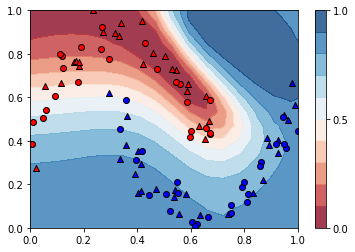

In [15]:
# make data for plot
xx, yy = np.meshgrid(np.linspace(-0.1, 1.1, 20), np.linspace(-0.1, 1.1, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# start plot
plt.figure()
cm = plt.cm.RdBu  

# plot decision regions
predictions_grid = [qclassifier(var, x=x) for x in X_grid]
Z = np.reshape(predictions_grid, xx.shape)
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0., 1.1, 0.1), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.5, 1])

# plot data
plt.scatter(X_train[:, 0][Y_train==0], X_train[:, 1][Y_train==0], c='r', marker='^', edgecolors='k')
plt.scatter(X_train[:, 0][Y_train==1], X_train[:, 1][Y_train==1], c='b', marker='^', edgecolors='k')
plt.scatter(X_val[:, 0][Y_val==0], X_val[:, 1][Y_val==0], c='r', marker='o', edgecolors='k')
plt.scatter(X_val[:, 0][Y_val==1], X_val[:, 1][Y_val==1], c='b', marker='o', edgecolors='k')

plt.xlim(0., 1)
plt.ylim(0., 1)
plt.show()